## 0. Get Setup
Import the code and libraries

In [ ]:
import torch 
import torchvision

import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    !pip install torchinfo
    from torchinfo import summary

try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3815, done.
remote: Counting objects: 100% (458/458), done.
remote: Compressing objects: 100% (252/252), done.
remote: Total 3815 (delta 242), reused 403 (delta 199), pack-reused 3357
Receiving objects: 100% (3815/3815), 650.61 MiB | 41.83 MiB/s, done.
Resolving deltas: 100% (2198/2198), done.
Updating files: 100% (248/248), done.


In [ ]:
#Hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
img_size = 224
batch_size = 32

## 1. Get Data

Getting data for the model.

In [ ]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and Dataloaders

In [ ]:
manual_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [ ]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir, test_dir, manual_transforms, batch_size)

### 2.3 Visualize a single image

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

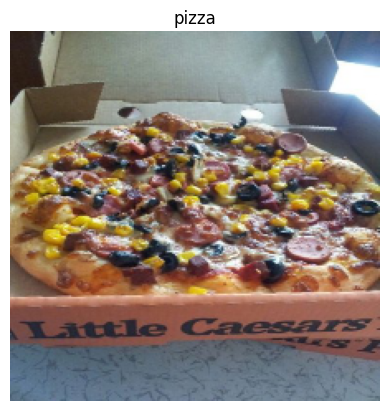

In [ ]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[1], label_batch[1]

#Plot the image with matplotlib
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

#3. Replicating ViT

##Equations for the model


```python 
#Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ..., image_patch_N] +
[class_token_pos, image_patch_1_pos, image_patch_2_pos, ..., image_patch_N_pos]

#Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

#Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block

#Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
```

##1. Table

<img src = "https://camo.githubusercontent.com/a8c0d4fbc98ae4b5f6df943d98b85ca1503bd8e223fbf479adf152b95272a50c/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f7079746f7263682d646565702d6c6561726e696e672f6d61696e2f696d616765732f30382d7669742d70617065722d7461626c652d312e706e67" width = 700>

- ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture
- ViT-B/16 = ViT-Base with image patch size 16x16
- Layers - the number of transformer encoder layers
- Hidden size $D$ - the embedding size throughout the architecture
- MLP size - the number of hidden units/neurons in the MLP
- Heads - the number of multi-head self-attention

#4. Equation 1: Split data into patches and creating the class, position and patch embedding

- Input shape: $H\times{W}\times{C}$ (heights x width x channels)
- Output shape: $N \times\left(P^{2} \cdot C\right)$
- H = height
- W = width
- C = color channels
- P = patch size
- N = number of patches = (height * width) / p^2
- D = constant latent vector size = embedding dimension

In [ ]:
16 ** 2

256

In [ ]:
64 * 64

4096

In [ ]:
(224 * 224) / (16 * 16)

196.0

In [ ]:
#example values
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [ ]:
#Input shape
embedding_layer_input_shape = (height, width, color_channels)

embedding_layer_output_shape = (number_of_patches, patch_size ** 2 * color_channels)
print(f"Input Shape (single 2D Image): {embedding_layer_input_shape}")
print(f"Output Shape (single 2D Image): {embedding_layer_output_shape}")

Input Shape (single 2D Image): (224, 224, 3)
Output Shape (single 2D Image): (196, 768)


### 4.2 Turning a single image into patches

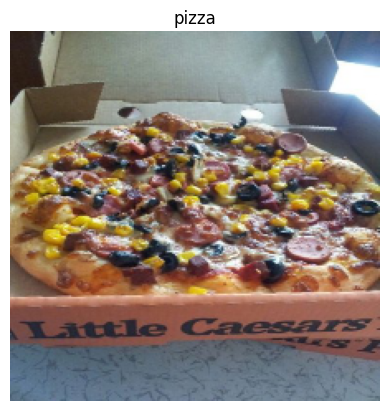

In [ ]:
#View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

<Figure size 1600x1600 with 0 Axes>

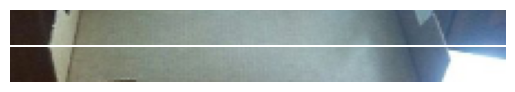

In [ ]:
plt.figure(figsize = (16, 16))
fig, ax = plt.subplots(nrows = 2)
ax[0].imshow(image.permute(1, 2, 0)[:16, :, :])
ax[0].axis("off")
ax[1].imshow(image.permute(1, 2, 0)[16:32, :, :])
ax[1].axis("off")
plt.subplots_adjust(wspace=0.1, hspace=-0.89)

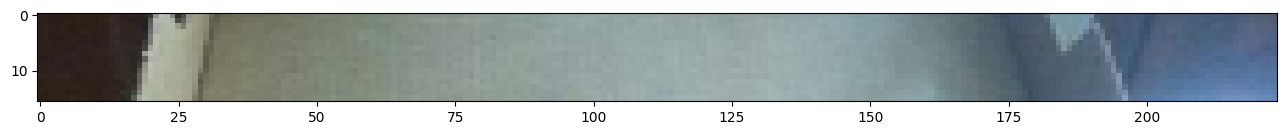

In [ ]:
#Get the top row
image_permuted = image.permute(1, 2, 0)

#Index to plot the row of pixels
plt.figure(figsize = (patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

In [ ]:
image.shape[0]

3

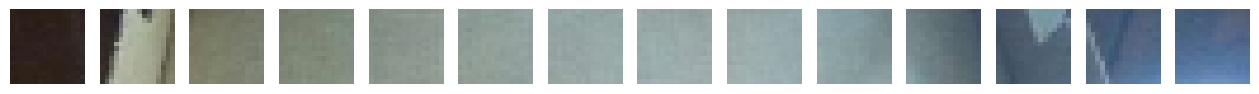

In [ ]:
#Setup code to plot the row as patches
num_patches = img_size / patch_size
assert img_size % patch_size == 0

#Create series of subplots
fig, axs = plt.subplots(nrows = 1, ncols = img_size // patch_size, sharex = True, sharey = True, figsize = (patch_size, patch_size))

#Iterate through number of patches
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch: patch+patch_size, :])

    axs[i].axis(False)

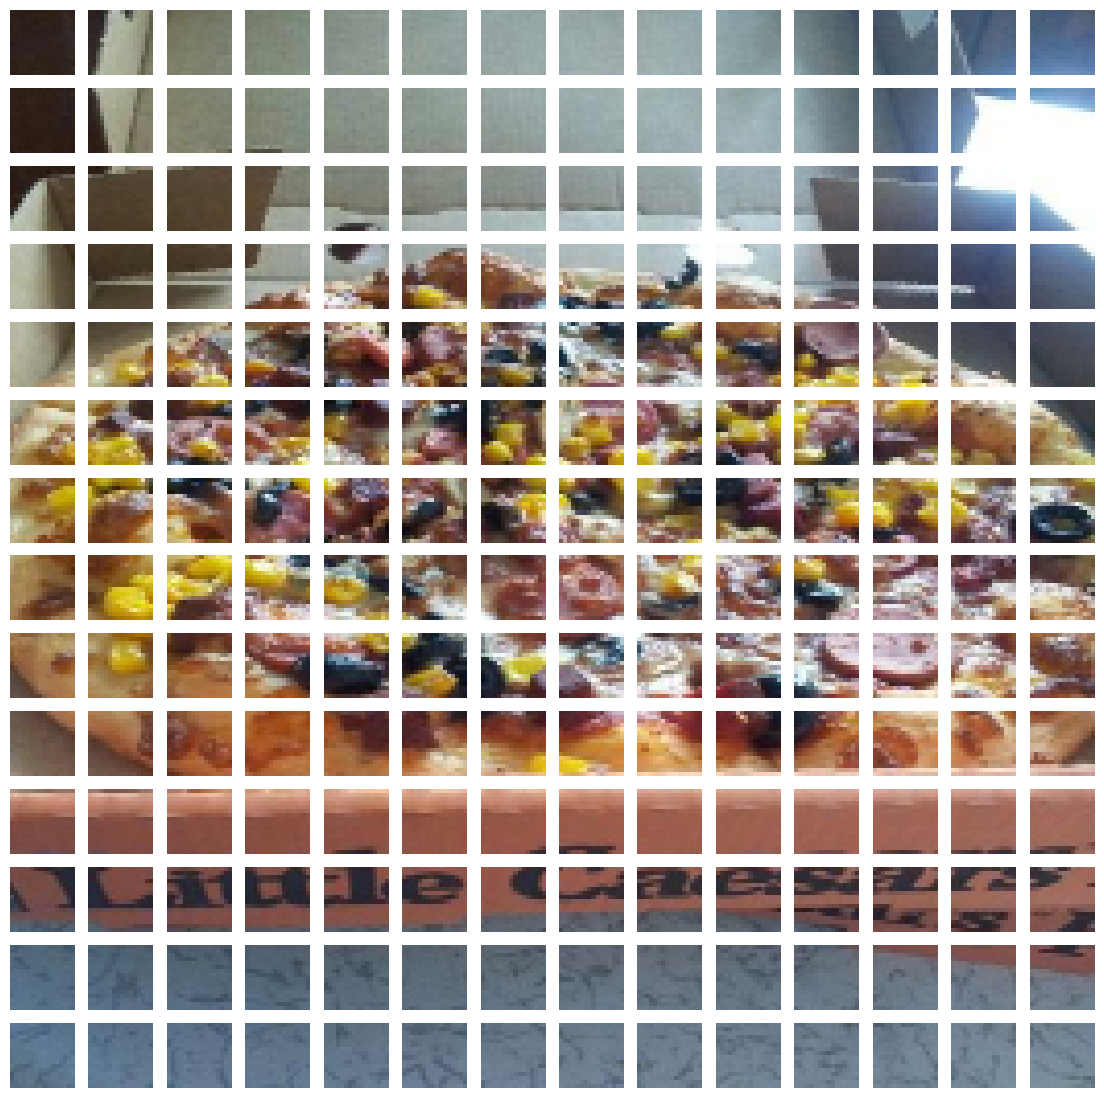

In [ ]:
#Setup code to plot whole image
fig, axs = plt.subplots(nrows = img_size // patch_size, ncols = img_size // patch_size, sharex = True, sharey = True, figsize = (num_patches, num_patches))
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(image_permuted[patch_height:patch_height + patch_size,
                                        patch_width:patch_width + patch_size,
                                        :])
        axs[i, j].axis(False)

##4.3 Creating image patches and turnint them into patch embeddings

In [ ]:
conv2d = nn.Conv2d(in_channels = 3, out_channels = 768, kernel_size = patch_size, stride = patch_size, padding = 0)

In [ ]:
image_out_of_conv = conv2d(image.unsqueeze(dim = 0))

In [ ]:
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [ ]:
import random
random_indexs = random.sample(range(0, 768), k = 5)
print(random_indexs)

[99, 215, 333, 217, 142]


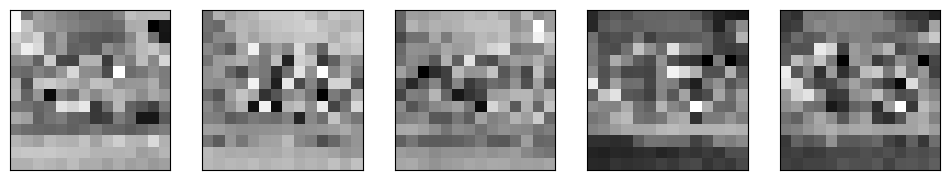

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (12, 12))

for i, idx in enumerate(random_indexs):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy(), cmap = "gray")
    axs[i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

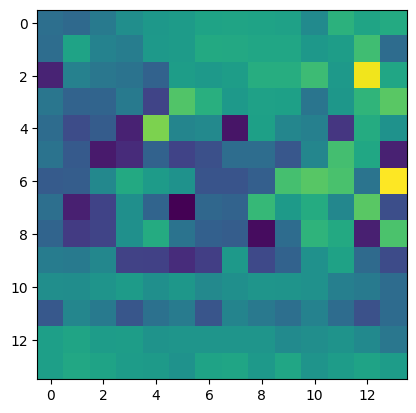

In [ ]:
plt.imshow(image_out_of_conv[:, 87, :, :].detach().permute(1, 2, 0).numpy())

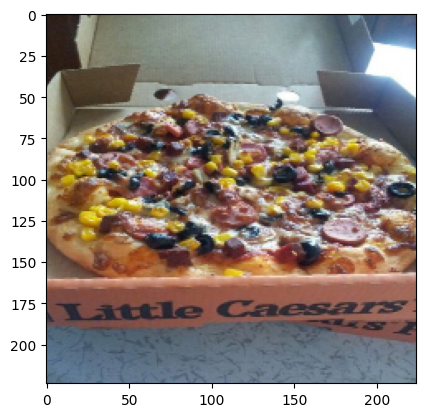

In [ ]:
plt.imshow(image.permute(1, 2, 0))

In [ ]:
flat = nn.Flatten(start_dim = 2, end_dim = 3)
(flat(image_out_of_conv).permute(0, 2, 1)).shape

torch.Size([1, 196, 768])

##4.5 Turning the ViT patch embedding layer into a PyTorch module

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels = 3, patch_size = 16, embedding_dim = 768):
        super().__init__()

        self.patcher = nn.Conv2d(in_channels, out_channels = 768, kernel_size = patch_size, stride = patch_size, padding = 0)
        self.flatten = nn.Flatten(start_dim = 2, end_dim = 3)

    def forward(self, x):
        image_res = x.shape[-1]
        assert image_res % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_res}, patch size: {self.patch_size}"

        x_patched = self.patcher(x)
        x_flatten = self.flatten(x_patched)
        return x_flatten.permute(0, 2, 1)

In [ ]:
patchify = PatchEmbedding()
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(dim = 0))
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [ ]:
rand_image_tensor = torch.rand((1, 3, 224, 224))
patchify(rand_image_tensor).shape

torch.Size([1, 196, 768])

###4.6 Creating the class token embedding

In [ ]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [ ]:
#Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [ ]:
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad = True)
class_token.shape

torch.Size([1, 1, 768])

In [ ]:
#Add the class token embedding to the front of the embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim = 1)
print(patch_embedded_image_with_class_embedding)

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-3.0312e-02,  1.3290e-01, -5.5687e-02,  ...,  4.4888e-02,
           3.8286e-02,  7.7479e-02],
         [ 6.1477e-04,  3.6185e-01, -1.6359e-01,  ...,  1.7746e-02,
           1.8957e-02,  2.7372e-01],
         ...,
         [ 1.2778e-02,  1.8515e-01, -1.7774e-01,  ..., -3.3044e-03,
           1.6802e-01,  2.0361e-01],
         [-2.2330e-03,  1.8947e-01, -1.6072e-01,  ...,  6.2547e-02,
           1.8943e-01,  2.5067e-01],
         [ 4.1110e-02,  1.7828e-01, -1.8789e-01,  ...,  1.8792e-02,
           1.4971e-01,  1.9672e-01]]], grad_fn=<CatBackward0>)


##4.7 Creating the position embedding

In [ ]:
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
            1.0000e+00,  1.0000e+00],
          [-3.0312e-02,  1.3290e-01, -5.5687e-02,  ...,  4.4888e-02,
            3.8286e-02,  7.7479e-02],
          [ 6.1477e-04,  3.6185e-01, -1.6359e-01,  ...,  1.7746e-02,
            1.8957e-02,  2.7372e-01],
          ...,
          [ 1.2778e-02,  1.8515e-01, -1.7774e-01,  ..., -3.3044e-03,
            1.6802e-01,  2.0361e-01],
          [-2.2330e-03,  1.8947e-01, -1.6072e-01,  ...,  6.2547e-02,
            1.8943e-01,  2.5067e-01],
          [ 4.1110e-02,  1.7828e-01, -1.8789e-01,  ...,  1.8792e-02,
            1.4971e-01,  1.9672e-01]]], grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
#Calculate N
number_of_batches = int(height * width) / patch_size ** 2

#Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

#Create the learnable 1D Position embedding
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension))

In [ ]:
position_embedding

Parameter containing:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True)

In [ ]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

In [ ]:
set_seeds()

patch_size = 16
print(f"Image tensor shapes: {image.shape}")
height, width = image.shape[1], image.shape[2]

# Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels = 3, patch_size = patch_size, embedding_dim = 768)

# Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad = True)

print(f"Class token embedding shape: {class_token.shape} | Batch size: {batch_size}")

# Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim = 1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# Create position embedding
number_of_patches = int((height * width ) // patch_size ** 2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dimension), requires_grad = True)

# Adding the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shapes: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768]) | Batch size: 1
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim):
        super().__init__()

        self.patcher = nn.Conv2d(in_channels, out_channels = 768, kernel_size = patch_size, stride = patch_size, padding = 0)
        self.flatten = nn.Flatten(start_dim = 2, end_dim = 3)
        self.patch_size = patch_size

        self.class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad = True)
        self.position_embedding = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dimension), requires_grad = True)

    def forward(self, x):
        image_res = x.shape[-1]
        assert image_res % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_res}, patch size: {self.patch_size}"

        x_patched = self.patcher(x)
        x_flatten = self.flatten(x_patched)
        x_flatten_permuted = x_flatten.permute(0, 2, 1)
        
        batch_size = x_flatten_permuted.shape[0]
        embedding_dimension = x_flatten_permuted.shape[-1]

        patch_embedding_class_token = torch.cat((class_token, x_flatten_permuted), dim = 1)
        number_of_patches = x_flatten_permuted.shape[1]

        return patch_embedding_class_token + self.position_embedding

In [ ]:
patched = PatchEmbedding(in_channels = image.permute(1, 2, 0).shape[-1], patch_size = 16, embedding_dim = ((patch_size ** 2) * image.permute(1, 2, 0).shape[-1]))

In [ ]:
patched(image.unsqueeze(dim = 0)).shape

torch.Size([1, 197, 768])

##Equation 2: Multihead Self-Attention (MSA Block)

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dim = 768, num_heads = 12, attention_dropout = 0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
        self.msa = nn.MultiheadAttention(embedding_dim, num_heads, attention_dropout, batch_first = True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.msa(query = x, key = x, value = x, need_weights = False)
        return attn_output

In [ ]:
msa = MultiHeadSelfAttentionBlock()
msa_output = msa(patched(image.unsqueeze(dim = 0)))
print(f"Patched: {patched(image.unsqueeze(dim = 0)).shape} | Output shape: {msa_output.shape}")

Patched: torch.Size([1, 197, 768]) | Output shape: torch.Size([1, 197, 768])


##Equation 3: Multilayer Perceptron

In [ ]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int=0.1):
    super().__init__()
    
    # Create the norm layer (LN) 
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout) 
    )
  
  def forward(self, x):
    x = self.layer_norm(x) 
    x = self.mlp(x)
    return x

In [ ]:
mlp = MLPBlock()
mlp_output_from_msa_output = mlp(msa(patched(image.unsqueeze(dim = 0))))

In [ ]:
class TransformerEncoder(nn.Module):

    def __init__(self,
                 embedding_dim = 768,
                 num_heads = 12,
                 mlp_size = 3072, 
                 attention_dropout = 0,
                 mlp_dropout = 0.1):
        
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
        self.msa = nn.MultiheadAttention(embed_dim = embedding_dim,
                                         num_heads = num_heads, 
                                         dropout = attention_dropout,
                                         batch_first = True)
        self.mlp = nn.Sequential(
            nn.Linear(in_features = embedding_dim, out_features = mlp_size),
            nn.GELU(),
            nn.Dropout(p = mlp_dropout),
            nn.Linear(in_features = mlp_size, out_features = embedding_dim),
            nn.Dropout(p = mlp_dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        atten_output, _ = self.msa(query = x, key = x, value = x, need_weights = False)

        x = self.layer_norm(atten_output)
        return self.mlp(x)

In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768, # Hidden size D from table 1, 768 for ViT-Base
               num_heads:int=12, # from table 1
               mlp_size:int=3072, # from table 1
               mlp_dropout:int=0.1, # from table 3
               attn_dropout:int=0):
    super().__init__()

    # Create MSA block (equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attention_dropout = attn_dropout)
    
    # Create MLP block (equation 3)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim, 
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)
    
  def forward(self, x):
    x = self.msa_block(x) + x # residual/skip connection for equation 2
    x = self.mlp_block(x) + x # residual/skip connection for equation 3
    return x 

In [ ]:
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768, # from Table 1 
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [ ]:
# Manual TransformerEncoder
transformer = TransformerEncoder()
transformer_result = transformer(patched(image.unsqueeze(dim = 0)))

In [ ]:
# Used other equations
transformer_used = TransformerEncoderBlock()
transformer_used_result = transformer_used(patched(image.unsqueeze(dim = 0)))

In [ ]:
summary(model = transformer,
        input_size = patched(image.unsqueeze(dim = 0)).shape,
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 30,
        row_settings = ["var_names"])

Layer (type (var_name))                  Input Shape                    Output Shape                   Param #                        Trainable
TransformerEncoder (TransformerEncoder)  [1, 197, 768]                  [1, 197, 768]                  --                             True
├─LayerNorm (layer_norm)                 [1, 197, 768]                  [1, 197, 768]                  1,536                          True
├─MultiheadAttention (msa)               --                             [1, 197, 768]                  2,362,368                      True
├─LayerNorm (layer_norm)                 [1, 197, 768]                  [1, 197, 768]                  (recursive)                    True
├─Sequential (mlp)                       [1, 197, 768]                  [1, 197, 768]                  --                             True
│    └─Linear (0)                        [1, 197, 768]                  [1, 197, 3072]                 2,362,368                      True
│    └─GELU (1)       

In [ ]:
summary(model = transformer_used,
        input_size = patched(image.unsqueeze(dim = 0)).shape,
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 30,
        row_settings = ["var_names"])

Layer (type (var_name))                            Input Shape                    Output Shape                   Param #                        Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]                  [1, 197, 768]                  --                             True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]                  [1, 197, 768]                  --                             True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]                  [1, 197, 768]                  1,536                          True
│    └─MultiheadAttention (msa)                    --                             [1, 197, 768]                  2,362,368                      True
├─MLPBlock (mlp_block)                             [1, 197, 768]                  [1, 197, 768]                  --                             True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]                  [1, 197, 768]      

##7.2 Create a Transformer Encoder Layer with In-Built Pytorch Layers

In [ ]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = 768,
                                                             nhead = 12,
                                                             dim_feedforward = 3072,
                                                             dropout = 0.1,
                                                             activation = "gelu",
                                                             batch_first = True,
                                                             norm_first = True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
summary(model = torch_transformer_encoder_layer,
        input_size = patched(image.unsqueeze(dim = 0)).shape,
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 30,
        row_settings = ["var_names"])

Layer (type (var_name))                            Input Shape                    Output Shape                   Param #                        Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]                  [1, 197, 768]                  7,087,872                      True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

##8. Putting it all together to create ViT

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Create a ViT class

class ViT(nn.Module):
    def __init__(self, 
                 img_size = 224, 
                 in_channels = 3, 
                 patch_size = 16, 
                 num_transformer_layer = 12, 
                 embedding_dim = 768, 
                 mlp_size = 3072, 
                 num_heads = 12,
                 attn_dropout = 0, 
                 mlp_dropout = 0.1, 
                 embedding_dropout = 0.1, 
                 num_classes = 1000):

        super().__init__()

        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"

        self.num_patches = (img_size * img_size) // patch_size ** 2

        self.class_embedding = nn.Parameter(data = torch.randn(1, 1, embedding_dim), requires_grad = True)
        self.positional_embedding = nn.Parameter(data = torch.randn(1, self.num_patches + 1, embedding_dim))

        self.embedding_dropout = nn.Dropout(p = embedding_dropout)

        self.patch_embedding = PatchEmbedding(in_channels = in_channels, patch_size = patch_size, embedding_dim = embedding_dim)

        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoderBlock(embedding_dim = embedding_dim, 
                                 num_heads = num_heads, 
                                 mlp_size = mlp_size, 
                                 mlp_dropout = mlp_dropout) for _ in range(num_transformer_layer)]
        ) 
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape = embedding_dim),
            nn.Linear(embedding_dim, 1000)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.positional_embedding + x
        x = self.embedding_dropout(x)
        
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])
        return x

In [ ]:
vit = ViT(num_classes = 1000)

In [ ]:
random_image_tensor = torch.randn(1, 3, 224, 224)
vit(random_image_tensor)

In [ ]:
from torchinfo import summary

summary(model=ViT(num_classes=len(class_names)),
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.parameters(), lr = 1e-3, betas = (0.9, 0.999), weight_decay = 0.1)

In [ ]:
from going_modular.going_modular import data_setup, engine
resutls = engine.train(vit, train_dataloader, test_dataloader, epochs = 10, optimizer = optimizer, loss_fn = loss_fn, device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5385 | train_acc: 0.3511 | test_loss: 1.6894 | test_acc: 0.2533
Epoch: 2 | train_loss: 1.2839 | train_acc: 0.3556 | test_loss: 1.1315 | test_acc: 0.4133
Epoch: 3 | train_loss: 1.2888 | train_acc: 0.2978 | test_loss: 1.1711 | test_acc: 0.2533
Epoch: 4 | train_loss: 1.3013 | train_acc: 0.3422 | test_loss: 1.2330 | test_acc: 0.2533
Epoch: 5 | train_loss: 1.2751 | train_acc: 0.3378 | test_loss: 1.2649 | test_acc: 0.2533
Epoch: 6 | train_loss: 1.2960 | train_acc: 0.3289 | test_loss: 1.2819 | test_acc: 0.2533
Epoch: 7 | train_loss: 1.2809 | train_acc: 0.3244 | test_loss: 1.2304 | test_acc: 0.3333
Epoch: 8 | train_loss: 1.2609 | train_acc: 0.3467 | test_loss: 1.2330 | test_acc: 0.2533
Epoch: 9 | train_loss: 1.2371 | train_acc: 0.3378 | test_loss: 1.1466 | test_acc: 0.4133
Epoch: 10 | train_loss: 1.1976 | train_acc: 0.3244 | test_loss: 1.1580 | test_acc: 0.2533
